In [11]:
import json
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
from matplotlib.colors import LogNorm

## Task 1

In [12]:
f = lambda x: x[0] < 19 
def conduct_experiments_pi(env, pi, num_experiments):
    total_reward = []
    for _ in range(num_experiments):
        observation, flag = env.reset(), False
        while flag is False:
            observation, reward, flag, info = env.step(f(observation))
        total_reward.append(reward)
    env.close()
    return np.mean(total_reward)
env = gym.make("Blackjack-v1", natural=True)
avg_reward = conduct_experiments_pi(env, f, num_experiments=100000)
print('Simple strategy Average reward: ', avg_reward)

Simple strategy Average reward:  -0.19168


In [13]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=1):
    observation = env.reset()

    s = IDXS[observation]

    done = False
    while not done:
        pi = compute_policy_by_Q(env, Q)
        a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)

        observation, reward, done, info = env.step(a)
        s_prime = IDXS[observation]

        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max(Q[s_prime]) - Q[s][a])
        s = s_prime
    return Q

def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax(Q, axis=1)

def Q_learning(env, total_episodes, alpha, epsilon, gamma):
    Q = np.zeros((nS, nA))
    pi = compute_policy_by_Q(env, Q)

    for n in range(total_episodes):
        Q = Q_learning_episode(env, pi, Q, alpha, epsilon, gamma)

    return Q

def conduct_experiments_pi(env, pi, num_experiments):
    total_reward = []
    for _ in range(num_experiments):
        observation = env.reset()
        s = IDXS[observation]
        done = False
        while not done:
            observation, reward, done, info = env.step(pi[s])
            s = IDXS[observation]
        total_reward.append(reward)
    env.close()
    return np.mean(total_reward)

# Q-learning reward for simple strategy
Q = Q_learning(env, total_episodes=100000, alpha=0.05, epsilon=0.1, gamma=1)
pi = compute_policy_by_Q(env, Q)
avg_reward = conduct_experiments_pi(env, pi, num_experiments=500000)
print('Q-learning average reward: ', avg_reward)

Q-learning average reward:  -0.163892


In [100]:
# Hyperparameters Tunning
epsilon, alpha, reward_dict = np.arange(0.75, 1, 0.05), [0.00001, 0.00003, 0.00005, 0.00007, 0.00009], dict()
for e in epsilon:
    for a in alpha:
        Q = Q_learning(env, total_episodes=100000, alpha=a, epsilon=e, gamma=1)
        pi = compute_policy_by_Q(env, Q)
        avg_reward = conduct_experiments_pi(env, pi, num_experiments=50000)
        reward_dict['e=' + str(e) + ' ' + 'a=' + str(a)] = avg_reward
        #print(f"Epsillon = {e}, alpha = {a}, reward = {avg_reward}")
        print("epsilon=%.4f, alpha = %.4f, reward = %.4f" % (e, a, avg_reward) )

epsilon=0.7500, alpha = 0.0000, reward = -0.0321
epsilon=0.7500, alpha = 0.0000, reward = -0.0411
epsilon=0.7500, alpha = 0.0001, reward = -0.0271
epsilon=0.7500, alpha = 0.0001, reward = -0.0497
epsilon=0.7500, alpha = 0.0001, reward = -0.0350
epsilon=0.8000, alpha = 0.0000, reward = -0.0336
epsilon=0.8000, alpha = 0.0000, reward = -0.0379
epsilon=0.8000, alpha = 0.0001, reward = -0.0319
epsilon=0.8000, alpha = 0.0001, reward = -0.0280
epsilon=0.8000, alpha = 0.0001, reward = -0.0313
epsilon=0.8500, alpha = 0.0000, reward = -0.0368
epsilon=0.8500, alpha = 0.0000, reward = -0.0304
epsilon=0.8500, alpha = 0.0001, reward = -0.0275
epsilon=0.8500, alpha = 0.0001, reward = -0.0338
epsilon=0.8500, alpha = 0.0001, reward = -0.0290
epsilon=0.9000, alpha = 0.0000, reward = -0.0272
epsilon=0.9000, alpha = 0.0000, reward = -0.0229
epsilon=0.9000, alpha = 0.0001, reward = -0.0314
epsilon=0.9000, alpha = 0.0001, reward = -0.0232
epsilon=0.9000, alpha = 0.0001, reward = -0.0327
epsilon=0.9500, alph

In [101]:
max_key = max(reward_dict, key=reward_dict.get)
print('Best hyperparameters: ', max_key)

Best hyperparameters:  e=0.9000000000000001 a=3e-05


In [102]:
print('Q-learning strategy average reward with best hyperparameters: ', reward_dict[max_key])

Q-learning strategy average reward with best hyperparameters:  -0.02293


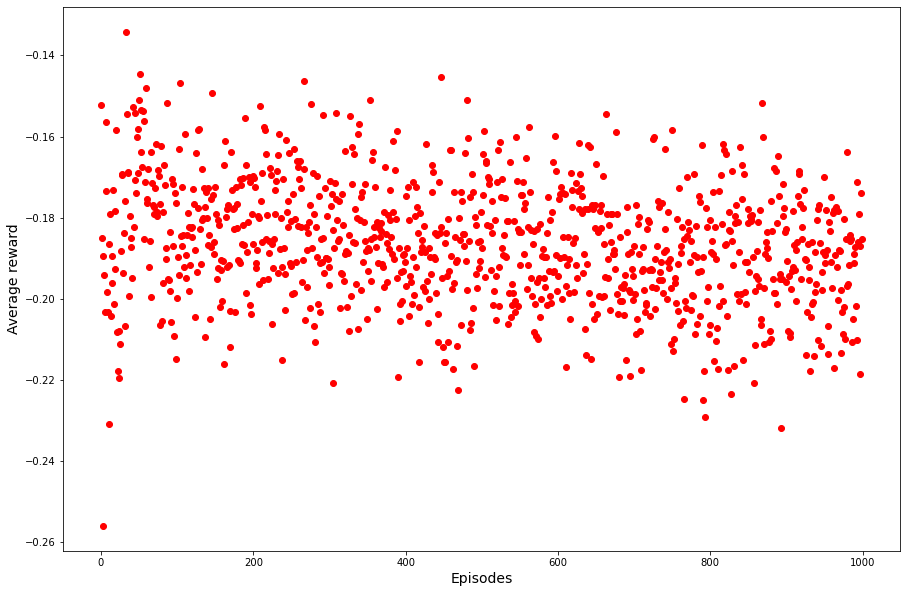

In [103]:
total_episodes, total_distribution, alpha, epsilon, gamma = 1000, 50, 0.95, 3e-5, 1
Q_all = [np.zeros((nS, nA))] * total_distribution
pi_all = [compute_policy_by_Q(env, Q) for Q in Q_all]
mean_episodes_reward = []
for _ in range(total_episodes):
    episode_reward = []
    for i in range(total_distribution):
        Q_all[i] = Q_learning_episode(env, pi_all[i], Q_all[i], alpha=alpha, epsilon=epsilon, gamma=gamma)
        pi_all[i] = compute_policy_by_Q(env, Q_all[i])
        episode_reward.append(conduct_experiments_pi(env, pi_all[i], 100))
    mean_episodes_reward.append(np.mean(episode_reward))

fig, ax = plt.subplots(figsize=(15, 10))

ax.set_xlabel("Episodes", fontsize=14)
ax.set_ylabel("Average reward", fontsize=14)

ax.plot(range(total_episodes), mean_episodes_reward, 'ro')
plt.show()

## Task 2

In [104]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):
    return sum_hand(hand) > 21


def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):
    return sorted(hand) == [1, 10]


class BlackjackDoubleEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=True, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()
        self.natural = natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2:
            done = True
            self.player.append(draw_card(self.np_random))
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer)) * 2
        else:
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [105]:
env = BlackjackDoubleEnv(natural=True)

In [106]:
# Define all possible states and actions
nS, nA, IDXS = possible_states([1, 0, 2], [], 4, 31, 1, 10, 12, 21)

In [107]:
Q = Q_learning(env, total_episodes=100000, alpha=1e-05, epsilon=0.95, gamma=1)
pi = compute_policy_by_Q(env, Q)
avg_reward = conduct_experiments_pi(env, pi, num_experiments=50000)
print(f'Q-learning strategy with double Average reward: ', avg_reward)

Q-learning strategy with double Average reward:  -0.01883


In [108]:
# Hyperparameters Tunning
epsilon, alpha, reward_dict = np.arange(0.75, 1, 0.05),  [0.00001, 0.00003, 0.00005, 0.00007, 0.00009], dict()
for e in epsilon:
    for a in alpha:
        Q = Q_learning(env, total_episodes=100000, alpha=a, epsilon=e, gamma=1)
        pi = compute_policy_by_Q(env, Q)
        avg_reward = conduct_experiments_pi(env, pi, num_experiments=50000)
        reward_dict['e=' + str(e) + ' ' + 'a=' + str(a)] = avg_reward
        #print(f"Epsillon = {e}, alpha = {a}, reward = {avg_reward}")
        print("epsilon=%.4f, alpha = %.4f, reward = %.4f" % (e, a, avg_reward) )

epsilon=0.7500, alpha = 0.0000, reward = -0.0353
epsilon=0.7500, alpha = 0.0000, reward = -0.0267
epsilon=0.7500, alpha = 0.0001, reward = -0.0377
epsilon=0.7500, alpha = 0.0001, reward = -0.0376
epsilon=0.7500, alpha = 0.0001, reward = -0.0304
epsilon=0.8000, alpha = 0.0000, reward = -0.0277
epsilon=0.8000, alpha = 0.0000, reward = -0.0403
epsilon=0.8000, alpha = 0.0001, reward = -0.0314
epsilon=0.8000, alpha = 0.0001, reward = -0.0222
epsilon=0.8000, alpha = 0.0001, reward = -0.0368
epsilon=0.8500, alpha = 0.0000, reward = -0.0248
epsilon=0.8500, alpha = 0.0000, reward = -0.0264
epsilon=0.8500, alpha = 0.0001, reward = -0.0265
epsilon=0.8500, alpha = 0.0001, reward = -0.0277
epsilon=0.8500, alpha = 0.0001, reward = -0.0254
epsilon=0.9000, alpha = 0.0000, reward = -0.0343
epsilon=0.9000, alpha = 0.0000, reward = -0.0301
epsilon=0.9000, alpha = 0.0001, reward = -0.0316
epsilon=0.9000, alpha = 0.0001, reward = -0.0245
epsilon=0.9000, alpha = 0.0001, reward = -0.0436
epsilon=0.9500, alph

In [109]:
max_key = max(reward_dict, key=reward_dict.get)
print('Best hyperparameters: ', max_key)

Best hyperparameters:  e=0.9500000000000002 a=7e-05


In [110]:
print('Q-learning with double strategy Average reward with best hyperparameters: ', reward_dict[max_key])

Q-learning with double strategy Average reward with best hyperparameters:  -0.01613


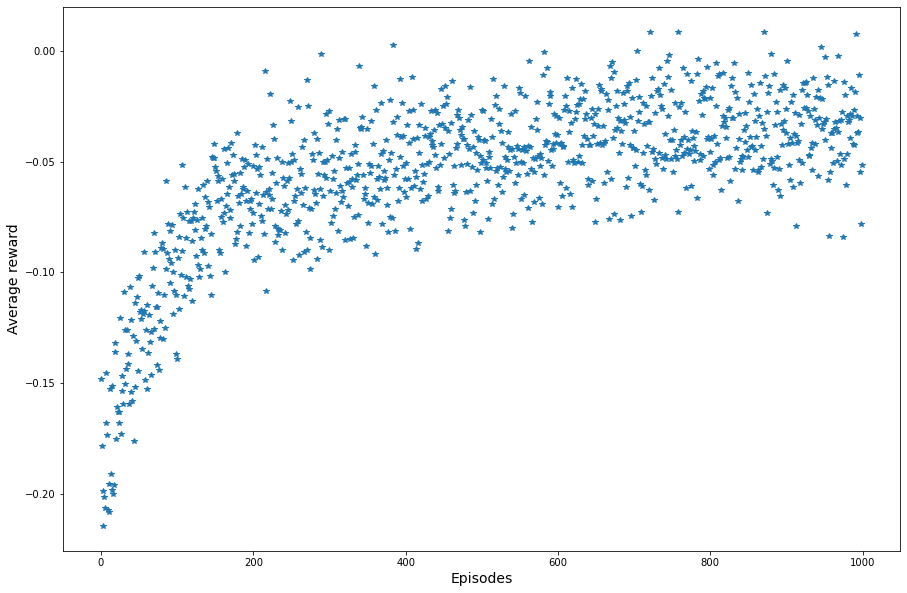

In [111]:
total_episodes, total_distribution, alpha, epsilon, gamma = 1000, 50, 7e-5, 0.95, 1
Q_all = [np.zeros((nS, nA))] * total_distribution
pi_all = [compute_policy_by_Q(env, Q) for Q in Q_all]
mean_episodes_reward = []
for _ in range(total_episodes):
    episode_reward = []
    for i in range(total_distribution):
        Q_all[i] = Q_learning_episode(env, pi_all[i], Q_all[i], alpha=alpha, epsilon=epsilon, gamma=gamma)
        pi_all[i] = compute_policy_by_Q(env, Q_all[i])
        episode_reward.append(conduct_experiments_pi(env, pi_all[i], 100))
    mean_episodes_reward.append(np.mean(episode_reward))

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel("Episodes", fontsize=14)
ax.set_ylabel("Average reward", fontsize=14)
ax.plot(range(total_episodes), mean_episodes_reward, '*')
plt.show()

## Task 3

In [2]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


crdvl = {1: -1, 2: 0.5, 3: 1, 4: 1, 5: 1.5, 6: 1, 7: 0.5, 8: 0, 9: -0.5, 10: -1}


def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):
    return sum_hand(hand) > 21


def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):
    return sorted(hand) == [1, 10]


class BlackjackDoubleCountingEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=True, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (
                spaces.Discrete(32),
                spaces.Discrete(11),
                spaces.Discrete(2),
                spaces.Discrete(89),
            )
        )
        self.seed()
        self.natural = natural
        self.sab = sab
        self.deck = deck * 4
        self.count = 0

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card)
        return card

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:
            player_card = self.draw_card(self.np_random)
            self.player.append(player_card)
            self.count += crdvl[player_card]
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2:
            done = True
            player_card = self.draw_card(self.np_random)
            self.player.append(player_card)
            self.count += crdvl[player_card]

            self.count += crdvl[self.dealer[1]]
            while sum_hand(self.dealer) < 17:
                dealer_card = self.draw_card(self.np_random)
                self.dealer.append(dealer_card)
                self.count += crdvl[dealer_card]
            reward = cmp(score(self.player), score(self.dealer)) * 2
        else:
            done = True
            self.count += crdvl[self.dealer[1]]
            while sum_hand(self.dealer) < 17:
                dealer_card = self.draw_card(self.np_random)
                self.dealer.append(dealer_card)
                self.count += crdvl[dealer_card]
            reward = cmp(score(self.player), score(self.dealer))
            if (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (
            sum_hand(self.player),
            self.dealer[0],
            usable_ace(self.player),
            self.count,
        )

    def reset(self):
        if len(self.deck) < 15:
            self.deck = deck * 4
            self.count = 0
        self.dealer = self.draw_hand(self.np_random)
        self.count += crdvl[self.dealer[0]]
        self.player = self.draw_hand(self.np_random)
        for card in self.player:
            self.count += crdvl[card]
        return self._get_obs()

In [3]:
env = BlackjackDoubleCountingEnv(natural=True)

In [122]:
Q = Q_learning(env, total_episodes=4000000, alpha=0.000000001, epsilon=0.9, gamma=gamma)
pi = compute_policy_by_Q(env, Q)
avg_reward = conduct_experiments_pi(env, pi, num_experiments=500000)
print('Q-learning strategy and count Average reward: ', avg_reward)

Q-learning strategy and count Average reward:  -0.012324


In [125]:
# Hyperparameters Tunning
epsilon, alpha, reward_dict = [0.9, 0.95], [0.00000001, 0.00000003, 0.00000005, 0.00000007, 0.00000009,
                                     0.000000001, 0.000000003, 0.000000005, 0.000000007, 0.000000009], dict()
for e in epsilon:
    for a in alpha:
        Q = Q_learning(env, total_episodes=4000000, alpha=a, epsilon=e, gamma=gamma)
        pi = compute_policy_by_Q(env, Q)
        avg_reward = conduct_experiments_pi(env, pi, num_experiments=500000)
        reward_dict['e=' + str(e) + ' ' + 'a=' + str(a)] = avg_reward
        print("epsilon=%.4f, alpha = %.4f, reward = %.4f" % (e, a, avg_reward) )

epsilon=0.9000, alpha = 0.0000, reward = -0.0140
epsilon=0.9000, alpha = 0.0000, reward = -0.0168
epsilon=0.9000, alpha = 0.0000, reward = -0.0146
epsilon=0.9000, alpha = 0.0000, reward = -0.0173
epsilon=0.9000, alpha = 0.0000, reward = -0.0162
epsilon=0.9000, alpha = 0.0000, reward = -0.0181
epsilon=0.9000, alpha = 0.0000, reward = -0.0173
epsilon=0.9000, alpha = 0.0000, reward = -0.0168
epsilon=0.9000, alpha = 0.0000, reward = -0.0171
epsilon=0.9000, alpha = 0.0000, reward = -0.0176
epsilon=0.9500, alpha = 0.0000, reward = -0.0172
epsilon=0.9500, alpha = 0.0000, reward = -0.0151
epsilon=0.9500, alpha = 0.0000, reward = -0.0141
epsilon=0.9500, alpha = 0.0000, reward = -0.0168
epsilon=0.9500, alpha = 0.0000, reward = -0.0172
epsilon=0.9500, alpha = 0.0000, reward = -0.0197
epsilon=0.9500, alpha = 0.0000, reward = -0.0128
epsilon=0.9500, alpha = 0.0000, reward = -0.0139
epsilon=0.9500, alpha = 0.0000, reward = -0.0158
epsilon=0.9500, alpha = 0.0000, reward = -0.0144


In [126]:
max_key = max(reward_dict, key=reward_dict.get)
print('Best hyperparameters: ', max_key)

Best hyperparameters:  e=0.95 a=3e-09


In [127]:
print('Q-learning with double and count strategy Average reward with best hyperparameters: ', reward_dict[max_key])

Q-learning with double and count strategy Average reward with best hyperparameters:  -0.01279


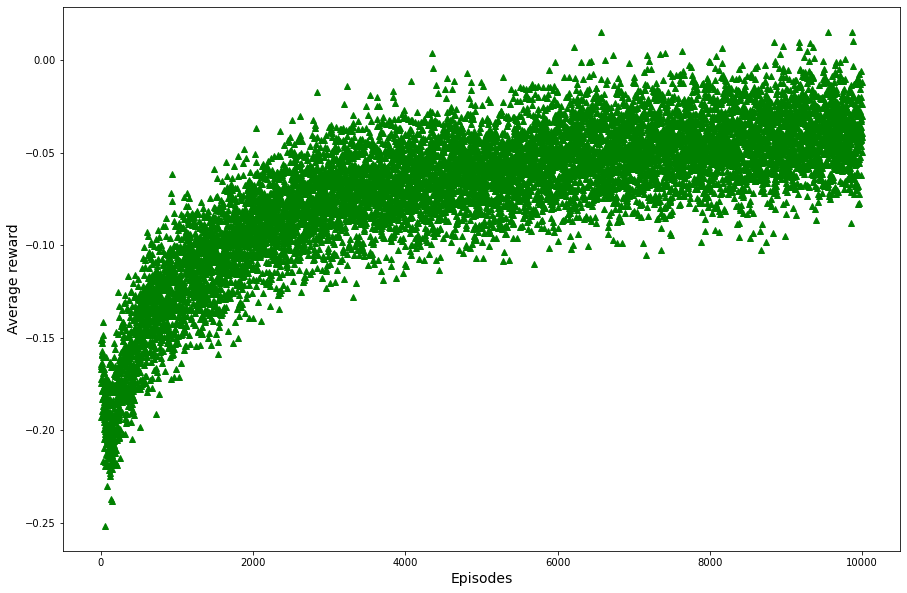

In [10]:
total_episodes, total_distribution, alpha, epsilon, gamma = 10000, 50, 3e-09, 0.95, 1
Q_all = [np.zeros((nS, nA))] * total_distribution
pi_all = [compute_policy_by_Q(env, Q) for Q in Q_all]
mean_episodes_reward = []
for _ in range(total_episodes):
    episode_reward = []
    for i in range(total_distribution):
        Q_all[i] = Q_learning_episode(env, pi_all[i], Q_all[i], alpha=alpha, epsilon=epsilon, gamma=gamma)
        pi_all[i] = compute_policy_by_Q(env, Q_all[i])
        episode_reward.append(conduct_experiments_pi(env, pi_all[i], 100))
    mean_episodes_reward.append(np.mean(episode_reward))

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel("Episodes", fontsize=14)
ax.set_ylabel("Average reward", fontsize=14)
ax.plot(range(total_episodes), mean_episodes_reward, 'g^')
plt.show()